# E-12. TrasnformerChatbot

- 목차

    0. 기본 준비
    1. 데이터 로드
    2. 전처리
    3. SubwordTextEncoder
    4. 모델 구성
    5. 학습 및 평가
    6. 모델 성능 개선
    7. 마치며

## 0. 기본 준비

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [31]:
path = '/content/drive/MyDrive/Aiffel/Exploration/E-12/'

In [32]:
plt.style.use(['dark_background'])

## 1. 데이터 로드

### 1.1. 데이터 확인

- 아래 링크에 공개 되어 있는 'songys'님의 데이터셋을 사용함
> https://github.com/songys/Chatbot_data

- Data description
    1. 챗봇 트레이닝용 문답 페어 11,876개
    2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

### 1.2. 경로 확인, 지정

In [33]:
os.listdir(path + 'data')

['ChatbotData .csv']

In [34]:
path_to_dataset = path + 'data/ChatbotData .csv'

## 2. 기본 전처리

- 아래에서 바로 확인할 수 있는 데이터셋을 보면 이미 어느 정도 정제된 데이터임을 알 수 있다.
> https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

- 위의 디스크립션에서 확인할 수 있듯, 문답 페어의 갯수가 약 12000개이므로 샘플을 줄이는 과정은 생략한다.

- 또한 실습과 달리 대화(또는 문답)이 1:1 비율로 작성되어있는 하나의 문서이기 때문에 전처리 과정에 차이가 있을 것.

### 2.1. 전처리 함수 지정

- preprocess

In [35]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  return sentence

In [36]:
T = open(path_to_dataset, 'r')
T.readlines()[0:5][4]

'3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0\n'

- 데이터셋 페어 구성 함수

In [37]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  
  # 라벨 데이터가 있으니 빈 리스트를 하나 더 생성, 따로 담을것.
  inputs, outputs, label = [], [], []
  # 데이터셋을 연다.
  with open(path_to_dataset, 'r') as file:
    # 줄 단위로 읽어오기.  
    lines = file.readlines()

  for line in lines[1:]:
    # 프로젝트의 데이터셋은 각 줄마다 쉼표 구분된 Q, A, label 로 구성 
    # 첫줄은 컬럼의 역할을 하므로 제외   
    # 줄바꿈 기호 제거
    # 쉼표 기준으로 스플릿한다
    conversation = line.replace('\n', '').split(',')
    # Q, A, label을 각각 전처리 후 리스트에 추가.
    inputs.append(preprocess_sentence(conversation[0]))
    outputs.append(preprocess_sentence(conversation[1]))
    label.append(conversation[2])

  return inputs, outputs, label

### 2.2. 스플릿

- QnA, label 스플릿

In [38]:
questions, answers, label = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [39]:
print('전처리 후의 100번째 질문 샘플: {}'.format(questions[99]))
print('전처리 후의 100번째 답변 샘플: {}'.format(answers[99]))

전처리 후의 100번째 질문 샘플: 거지 같이 일해 놓고 갔어
전처리 후의 100번째 답변 샘플: 일 못하는 사람이 있으면 옆에 있는 사람이 더 힘들죠 . 


## 3. SubwordTextEncoder

### 3.1. 단어장 만들기

In [40]:
import tensorflow_datasets as tfds
# 데이터 총량이 적고 사용된 어휘가 비교적 균일하다.
# 단어장 크기를 넉넉히 지정해본다.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=10500)

In [41]:
tokenizer.vocab_size

10077

### 3.2. 토큰화

In [42]:
# 인코딩 처리 후 예제
print('정수 인코딩 후의 100번째 질문 샘플: {}'.format(tokenizer.encode(questions[99])))
print('정수 인코딩 후의 100번째 답변 샘플: {}'.format(tokenizer.encode(answers[99])))

정수 인코딩 후의 100번째 질문 샘플: [1692, 9853, 76, 5536, 9853, 976, 3257]
정수 인코딩 후의 100번째 답변 샘플: [102, 862, 34, 151, 1342, 61, 34, 7, 676, 1]


In [43]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [44]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [10077]
END_TOKEN의 번호 : [10078]


In [45]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

10079


### 3.3. 최대 길이 제한과 패딩

- 문장의 길이를 확인해보자.

In [46]:
q_lens = [len(s.split()) for s in questions]
a_lens = [len(s.split()) for s in answers]
s_lens = [len(s.split()) for s in questions + answers]

In [47]:
np.std(q_lens)

1.8439116643228872

In [48]:
np.mean(q_lens)

3.9283599763173473

In [49]:
np.std(a_lens)

1.9021435205216073

In [50]:
np.mean(a_lens)

4.684936141419268

In [51]:
# 표준편차
np.std(s_lens)

1.9110682804767203

In [52]:
# 평균
np.mean(s_lens)

4.306648058868308

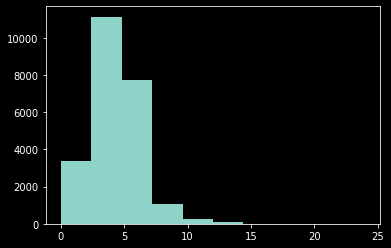

In [53]:
weight = s_lens

plt.hist(weight)

plt.show()

- 질문 문장과 답변 문장 간의 평균 및 편차가 그다지 차이나지 않는다. 최대 길이 제한을 일원화 해도 괜찮을 것 같다.
- 일차적으로 최대 문장 길이 제한은 정규분포의 올림인 7에 시작 및 끝 토큰을 더한 9로 정한다.

In [54]:
MAX_LENGTH = 9

In [55]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 9 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 9로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [56]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 10079
필터링 후의 질문 샘플 개수: 8405
필터링 후의 답변 샘플 개수: 8405


### 3.4. 교사강요 적용하기

In [57]:
BATCH_SIZE = 32
BUFFER_SIZE = 8405

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 구성

### 4.1. 트랜스포머 부품(?)준비

- 포지셔널 인코딩 클래스 생성

In [58]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- 어텐션

In [59]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [60]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

- 마스킹

In [61]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [62]:
# 패딩 마스킹 in 트랜스포머
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

- 인코더 / 디코더

In [63]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [64]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [65]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [66]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 4.2. 트랜스포머 모델 조립(?)

In [67]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


## 5. 학습 및 평가

### 5.1. 모델 정의

#### 5.1.1. 하이퍼파라미터 설정

In [68]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

#### 5.1.2. 손실함수 지정

In [69]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

#### 5.1.3. 학습률 설정

In [70]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

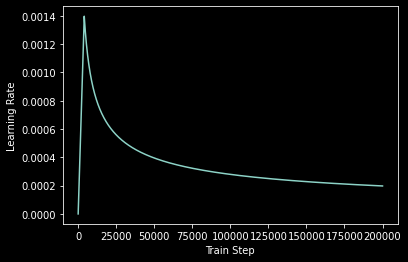

In [71]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 5.1.4. 컴파일

In [72]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 5.2. 학습(기본 설정)

In [106]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 6s 21ms/step - loss: 0.1411 - accuracy: 0.6743
Epoch 2/20
263/263 [==============================] - 6s 21ms/step - loss: 0.1294 - accuracy: 0.6769
Epoch 3/20
263/263 [==============================] - 6s 21ms/step - loss: 0.1155 - accuracy: 0.6811
Epoch 4/20
263/263 [==============================] - 6s 22ms/step - loss: 0.1055 - accuracy: 0.6829
Epoch 5/20
263/263 [==============================] - 6s 21ms/step - loss: 0.0956 - accuracy: 0.6855
Epoch 6/20
263/263 [==============================] - 6s 21ms/step - loss: 0.0848 - accuracy: 0.6877
Epoch 7/20
263/263 [==============================] - 6s 21ms/step - loss: 0.0806 - accuracy: 0.6889
Epoch 8/20
263/263 [==============================] - 10s 39ms/step - loss: 0.0746 - accuracy: 0.6909
Epoch 9/20
263/263 [==============================] - 6s 21ms/step - loss: 0.0699 - accuracy: 0.6915
Epoch 10/20
263/263 [==============================] - 8s 32ms/step - loss: 0.0687 - accur

### 5.3. 모델 실행

In [76]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break
                                                                                                                                                                                        
    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [77]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 아무래도 그렇겠죠 . 


'아무래도 그렇겠죠 . '

In [ ]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [ ]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 그땐 그게 맞다고 생각했으니까요 . 


'그땐 그게 맞다고 생각했으니까요 . '

### 5.4. 평가

: 
- 문장의 형태는 그럴듯 하나 동문서답이다

## 6. 모델 성능 개선

공통사항
- batch size = 32
- 손실함수, 학습률, 컴파일 실습과 동일


비고
- 배치사이즈 :

    따로 기록을 남기지 않았으나, 멀티 헤드를 비교하는 첫 번째 구간에서 크기를 몇 번 변경해 보았으나 거의 영향이 없었다.

### 6.1. 재실행 구간

백엔드 클리어 세션이라는 함수를 사용하여 비교 검증을 위해 특별히 지속적으로 재실행해야 할 부분은 없는 것 같다.



### 6.2. 하이퍼파라미터 수정 - NUM_HEAD

요약: 
- 생성된 문장을 기준으로, 넘헤드 갯수가 대단히 큰 영향을 미치지는 않는 것 같다.
- 동일 epoch에서 갯수가 많아지면 지표가 조금 더 좋다.
- 넘헤드의 갯수를 줄였을 때 생성된 문장이 연속적으로 더 적합했던 케이스가 있어 한동안 반복 실행했으나, 결과적으로 갯수가 줄어드는 것이 긍정적인 영향은 미치지 않는 것으로 보인다.
    > 바로 탈락시키지 않고, 다른 지표를 바꾸어 재검증 해 볼 것


#### 6.2.1. 멀티 헤드 갯수 늘려보기(1)

NUM_HEAD 

: 8 -> 16


In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    6634240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
328/328 [==============================] - 15s 28ms/step - loss: 5.6748 - accuracy: 0.1804
Epoch 2/20
328/328 [==============================] - 9s 28ms/step - loss: 3.7526 - accuracy: 0.2426
Epoch 3/20
328/328 [==============================] - 9s 28ms/step - loss: 3.2922 - accuracy: 0.2538
Epoch 4/20
328/328 [==============================] - 9s 28ms/step - loss: 3.0116 - accuracy: 0.2688
Epoch 5/20
328/328 [==============================] - 9s 28ms/step - loss: 2.7187 - accuracy: 0.2929
Epoch 6/20
328/328 [==============================] - 9s 28ms/step - loss: 2.3872 - accuracy: 0.3284
Epoch 7/20
328/328 [==============================] - 9s 28ms/step - loss: 2.0342 - accuracy: 0.3705
Epoch 8/20
328/328 [==============================] - 9s 28ms/step - loss: 1.6852 - accuracy: 0.4099
Epoch 9/20
328/328 [==============================] - 9s 29ms/step - loss: 1.3481 - accuracy: 0.4470
Epoch 10/20
328/328 [==============================] - 9s 28ms/step - loss: 1.0602 - accur

In [ ]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 믿음이 가장 중요하죠 . 


'믿음이 가장 중요하죠 . '

In [ ]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [ ]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 눈물 더 흘려도 돼요 . 


'눈물 더 흘려도 돼요 . '

In [ ]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 잠시 쉬어도 괜찮아요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 얼른 맛난 음식 드세요 . 
입력 : 지쳤어요
출력 : 아픔을 헤아려도 달라지는 건 없어요 . 
입력 : 공부하기 싫어요
출력 : 모든 일이 뜻대로 되진 않나봐요 . 
입력 : 저녁은 드셨나요?
출력 : 어떤 선택이든 후회가 남기 마련이지요 . 


('안녕하세요 . ',
 '잠시 쉬어도 괜찮아요 . ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '얼른 맛난 음식 드세요 . ',
 '아픔을 헤아려도 달라지는 건 없어요 . ',
 '모든 일이 뜻대로 되진 않나봐요 . ',
 '어떤 선택이든 후회가 남기 마련이지요 . ')

- 평가

    - 정확도 및 손실값 : 거의 차이 없음
    - 문장 구현 : 여전히 동문서답 중



#### 6.2.2. 멀티 헤드 갯수 늘려보기(2)

NUM_HEAD 

: 16 -> 32


In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 32 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    6634240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
328/328 [==============================] - 15s 28ms/step - loss: 5.6745 - accuracy: 0.1863
Epoch 2/20
328/328 [==============================] - 9s 28ms/step - loss: 3.7505 - accuracy: 0.2423
Epoch 3/20
328/328 [==============================] - 9s 28ms/step - loss: 3.2896 - accuracy: 0.2535
Epoch 4/20
328/328 [==============================] - 9s 28ms/step - loss: 3.0147 - accuracy: 0.2684
Epoch 5/20
328/328 [==============================] - 9s 28ms/step - loss: 2.7227 - accuracy: 0.2917
Epoch 6/20
328/328 [==============================] - 9s 28ms/step - loss: 2.3921 - accuracy: 0.3272
Epoch 7/20
328/328 [==============================] - 9s 28ms/step - loss: 2.0384 - accuracy: 0.3692
Epoch 8/20
328/328 [==============================] - 9s 28ms/step - loss: 1.6920 - accuracy: 0.4098
Epoch 9/20
328/328 [==============================] - 9s 28ms/step - loss: 1.3612 - accuracy: 0.4458
Epoch 10/20
328/328 [==============================] - 9s 28ms/step - loss: 1.0753 - accur

In [ ]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 인연이 여기까지였나봅니다 . 


'인연이 여기까지였나봅니다 . '

In [ ]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [ ]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 다시 연락을 했나봐요 . 


'다시 연락을 했나봐요 . '

In [ ]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 돈 없어도 할 수 있는게 많아요
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 무슨 일 있었나봐요 . 
입력 : 지쳤어요
출력 : 다시 썸부터 시작해도 좋을 것 같아요 . 
입력 : 공부하기 싫어요
출력 : 잠시 쉬어도 돼요 . 
입력 : 저녁은 드셨나요?
출력 : 눈을 깜빡거려보세요 . 


('안녕하세요 . ',
 '돈 없어도 할 수 있는게 많아요',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '무슨 일 있었나봐요 . ',
 '다시 썸부터 시작해도 좋을 것 같아요 . ',
 '잠시 쉬어도 돼요 . ',
 '눈을 깜빡거려보세요 . ')

- 평가

    - 정확도 및 손실값 : 거의 차이 없음
    - 문장 구현 : 더(?) 동문서답 중



#### 6.2.3. 멀티 헤드 갯수 줄여보기(1)

NUM_HEAD 

: 32 -> 4


In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    6634240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
328/328 [==============================] - 15s 27ms/step - loss: 5.6415 - accuracy: 0.1930
Epoch 2/20
328/328 [==============================] - 9s 28ms/step - loss: 3.7441 - accuracy: 0.2434
Epoch 3/20
328/328 [==============================] - 9s 27ms/step - loss: 3.2942 - accuracy: 0.2543
Epoch 4/20
328/328 [==============================] - 9s 27ms/step - loss: 3.0121 - accuracy: 0.2683
Epoch 5/20
328/328 [==============================] - 9s 27ms/step - loss: 2.7166 - accuracy: 0.2926
Epoch 6/20
328/328 [==============================] - 9s 27ms/step - loss: 2.3867 - accuracy: 0.3279
Epoch 7/20
328/328 [==============================] - 9s 27ms/step - loss: 2.0419 - accuracy: 0.3692
Epoch 8/20
328/328 [==============================] - 9s 27ms/step - loss: 1.6972 - accuracy: 0.4078
Epoch 9/20
328/328 [==============================] - 9s 27ms/step - loss: 1.3686 - accuracy: 0.4424
Epoch 10/20
328/328 [==============================] - 9s 27ms/step - loss: 1.0840 - accur

In [ ]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 아픔을 가늠할 수 없었으니까요 . 


'아픔을 가늠할 수 없었으니까요 . '

In [ ]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 부담스럽지 않은 선물이 좋겠네요 . 


'아직은 부담스럽지 않은 선물이 좋겠네요 . '

In [ ]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 인스타를 삭제하는게 좋겠네요 . 


'인스타를 삭제하는게 좋겠네요 . '

In [ ]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 볼 수 있어 좋은 가봐요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 그래서 표현이 중요해요 . 
입력 : 지쳤어요
출력 : 그래서 표현이 중요해요 . 
입력 : 공부하기 싫어요
출력 : 믿음이 더 필요해 보이네요 . 
입력 : 저녁은 드셨나요?
출력 : 볼 수 있을 거 같아요 . 


('안녕하세요 . ',
 '볼 수 있어 좋은 가봐요 . ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '그래서 표현이 중요해요 . ',
 '그래서 표현이 중요해요 . ',
 '믿음이 더 필요해 보이네요 . ',
 '볼 수 있을 거 같아요 . ')

- 평가

    - 정확도 및 손실값 : -
    - 문장 구현 : 비교적 응답이 적절해 보이는 갯수가 늘었으나 신뢰할 수 없다.



#### 6.2.4. 멀티 헤드 갯수 줄여보기(2)

NUM_HEAD 

: 4 -> 2


In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 2 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    6634240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
328/328 [==============================] - 15s 28ms/step - loss: 5.6431 - accuracy: 0.1812
Epoch 2/20
328/328 [==============================] - 9s 27ms/step - loss: 3.7421 - accuracy: 0.2431
Epoch 3/20
328/328 [==============================] - 9s 27ms/step - loss: 3.3144 - accuracy: 0.2521
Epoch 4/20
328/328 [==============================] - 9s 27ms/step - loss: 3.0502 - accuracy: 0.2661
Epoch 5/20
328/328 [==============================] - 9s 27ms/step - loss: 2.7636 - accuracy: 0.2876
Epoch 6/20
328/328 [==============================] - 9s 27ms/step - loss: 2.4272 - accuracy: 0.3231
Epoch 7/20
328/328 [==============================] - 9s 27ms/step - loss: 2.0759 - accuracy: 0.3635
Epoch 8/20
328/328 [==============================] - 9s 27ms/step - loss: 1.7194 - accuracy: 0.4023
Epoch 9/20
328/328 [==============================] - 9s 27ms/step - loss: 1.3824 - accuracy: 0.4400
Epoch 10/20
328/328 [==============================] - 9s 27ms/step - loss: 1.0947 - accur

In [ ]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 후회하지 않을 자신이 있다면 만나봐요 . 


'후회하지 않을 자신이 있다면 만나봐요 . '

In [ ]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [ ]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 알다가도 모르는게 연애 같아요 . 


'알다가도 모르는게 연애 같아요 . '

In [ ]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 더 생각이 나셨군요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 천천히 말해봐요 . 
입력 : 지쳤어요
출력 : 천천히 잊어가요 . 
입력 : 공부하기 싫어요
출력 : 충분한 대화를 나눴길 바랍니다 . 
입력 : 저녁은 드셨나요?
출력 : 자신의 존재를 알리는 게 우선이겠네요 . 


('안녕하세요 . ',
 '더 생각이 나셨군요 . ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '천천히 말해봐요 . ',
 '천천히 잊어가요 . ',
 '충분한 대화를 나눴길 바랍니다 . ',
 '자신의 존재를 알리는 게 우선이겠네요 . ')

- 평가

    - 정확도 및 손실값 : 여전히 큰 차이가 없으나, 헤드의 수가 줄어드니 지표가 감소하는 것 같다.
    - 문장 구현 : -



#### 6.2.5. 멀티 헤드 갯수 줄여보기(3)

NUM_HEAD 

: 2 -> 1

In [ ]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 1 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    6634240     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
328/328 [==============================] - 14s 27ms/step - loss: 5.6993 - accuracy: 0.1836
Epoch 2/20
328/328 [==============================] - 9s 27ms/step - loss: 3.7678 - accuracy: 0.2436
Epoch 3/20
328/328 [==============================] - 9s 27ms/step - loss: 3.3211 - accuracy: 0.2525
Epoch 4/20
328/328 [==============================] - 9s 27ms/step - loss: 3.0295 - accuracy: 0.2671
Epoch 5/20
328/328 [==============================] - 9s 27ms/step - loss: 2.7228 - accuracy: 0.2927
Epoch 6/20
328/328 [==============================] - 9s 26ms/step - loss: 2.3949 - accuracy: 0.3286
Epoch 7/20
328/328 [==============================] - 9s 27ms/step - loss: 2.0554 - accuracy: 0.3692
Epoch 8/20
328/328 [==============================] - 9s 26ms/step - loss: 1.7324 - accuracy: 0.4038
Epoch 9/20
328/328 [==============================] - 9s 27ms/step - loss: 1.4290 - accuracy: 0.4346
Epoch 10/20
328/328 [==============================] - 9s 27ms/step - loss: 1.1643 - accur

In [ ]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 좋아하는 감정은 정말 복잡하고 힘들어요 . 


'좋아하는 감정은 정말 복잡하고 힘들어요 . '

In [ ]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [ ]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 마음을 천천히 보듬어 주세요 . 


'마음을 천천히 보듬어 주세요 . '

In [ ]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 인연이 거기까지인가봐요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 본 웹툰이 있는지 먼저 물어보고싶네요 . 
입력 : 배고파요
출력 : 좀 더 편하게 생각해보세요 . 
입력 : 지쳤어요
출력 : 더 이상 신경쓰지 마세요 . 
입력 : 공부하기 싫어요
출력 : 조금만 더 버텨보세요 . 
입력 : 저녁은 드셨나요?
출력 : 마음은 좀 정리 되어가길 바랍니다 . 


('안녕하세요 . ',
 '인연이 거기까지인가봐요 . ',
 '제가 있잖아요 . ',
 '안 본 웹툰이 있는지 먼저 물어보고싶네요 . ',
 '좀 더 편하게 생각해보세요 . ',
 '더 이상 신경쓰지 마세요 . ',
 '조금만 더 버텨보세요 . ',
 '마음은 좀 정리 되어가길 바랍니다 . ')

- 평가

    - 정확도 및 손실값 : 더 감소했다. 헤드의 수에 영향을 받는 것이 어느 정도 확인된다.
    - 문장 구현 : -



### 6.3. vocab_size에 관련한 조정

기존
- traget_vocab_size = 2**14 / MAX_LENGTH = 9
- BUFFER_SIZE = 샘플 수

    >- 단어장의 크기 : 21797
    >- 필터링 후의 질문 샘플 개수: 10476
    >- 필터링 후의 답변 샘플 개수: 10476

- 샘플 수가 적고, 한 명이 작성한 인공 데이터셋임을 감안해 단어장 목표 사이즈를 넉넉하게 설정했었다.


참조
- 단어장 타겟 사이즈를 2^15, 2^16으로 변경해도 더 큰 단어장이 생성되지는 않는다.
- 예제 데이터의 기본 목표 사이즈였던 2^13의 경우 아래와 같다
    >- 단어장의 크기 : 8149
    >- 필터링 후의 질문 샘플 개수: 7843
    >- 필터링 후의 답변 샘플 개수: 7843
    >
    > 필터링 후 샘플 이 많이 손실된다고 판단
- 따라서 최대치 단어장 크기 목표 기준 샘플 갯수와 비슷한 목표 단어장을 설정해보았다.


변경
- traget_vocab_size = 10500 / MAX_LENGTH = 9
    >- 단어장의 크기 : 10079
    >- 필터링 후의 질문 샘플 개수: 8405
    >- 필터링 후의 답변 샘플 개수: 8405




### 위의 조절을 기준으로 재실행

6.3.에 대한 평가
- 전반적인 정확도가 올라갔다.
    > 단어장 설정의 기준 확보
- 멀티 헤드 갯수를 줄이는 것은 좋지 못한 생각이다.
    >- 정확도와 손실값 지표가 좋지 않고, 문장 구현 능력도 부족하다.
    >- 멀티 헤드의 갯수가 많을 수록 지표에 대한 수렴이 빠르기 때문에 epoch을 달리 해야 더 적절한 비교가 될 수 있다고 볼 수도 있으나, 학습 시간 비용을 고려하면 적절한 헤드 수를 사용하는 것이 좋다.
- 각각 1, 2, 4, 8, 16, 32 개의 헤드 수에서, 32개일 경우 지표가 가잫 좋았으나 문장 구현은 16에서 더 좋았다.
    > 하지만 기록하지 않은 수많은 학습 결과, 문장 생성 표본은 그다지 신뢰도가 높지 않으니 여전히 비교군에 유지한다.


6.3. 결과반영
- 목표 단어장 설정 10500
- 버퍼 사이즈 = 샘플 사이즈 = 8405
- 넘헤드 갯수 줄여보기 모델들은 탈락
     

#### 6.3.1. 기본 모델

loss: 0.0403 - accuracy: 0.6991

In [107]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 무엇이 다 말씀하세요 . 


'무엇이 다 말씀하세요 . '

In [108]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [109]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [110]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 자신을 먼저 사랑해주세요 . 
입력 : 배고파요
출력 : 뭐 좀 챙겨드세요 . 
입력 : 지쳤어요
출력 : 고생 많았어요 . 
입력 : 공부하기 싫어요
출력 : 새로운 스타일에 도전하는 것도 좋아요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '자신을 먼저 사랑해주세요 . ',
 '뭐 좀 챙겨드세요 . ',
 '고생 많았어요 . ',
 '새로운 스타일에 도전하는 것도 좋아요 . ',
 '맛있는 거 드세요 . ')

#### 6.3.2. 멀티 헤드 갯수 늘려보기(1)

NUM_HEAD 

: 8 -> 16


In [73]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [74]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 14s 22ms/step - loss: 5.6921 - accuracy: 0.1409
Epoch 2/20
263/263 [==============================] - 6s 22ms/step - loss: 4.0994 - accuracy: 0.2410
Epoch 3/20
263/263 [==============================] - 6s 24ms/step - loss: 3.5479 - accuracy: 0.2515
Epoch 4/20
263/263 [==============================] - 6s 22ms/step - loss: 3.2692 - accuracy: 0.2667
Epoch 5/20
263/263 [==============================] - 6s 22ms/step - loss: 2.9936 - accuracy: 0.2878
Epoch 6/20
263/263 [==============================] - 6s 22ms/step - loss: 2.6796 - accuracy: 0.3227
Epoch 7/20
263/263 [==============================] - 6s 22ms/step - loss: 2.3241 - accuracy: 0.3667
Epoch 8/20
263/263 [==============================] - 6s 22ms/step - loss: 1.9506 - accuracy: 0.4118
Epoch 9/20
263/263 [==============================] - 6s 22ms/step - loss: 1.5704 - accuracy: 0.4566
Epoch 10/20
263/263 [==============================] - 6s 22ms/step - loss: 1.2183 - accur

In [78]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 건강에 마음의 준비가 필요하겠네요 . 


'건강에 마음의 준비가 필요하겠네요 . '

In [79]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 잘 모르겠어요 . 


'잘 모르겠어요 . '

In [80]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [81]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 생각보다 힘든 일이 있었나봐요 . 
입력 : 배고파요
출력 : 맛난 거 드세요 . 
입력 : 지쳤어요
출력 : 지칠 때는 쉬어도 돼요 . 
입력 : 공부하기 싫어요
출력 : 잠시 쉬어도 괜찮습니다 . 
입력 : 저녁은 드셨나요?
출력 : 솔직한 사람에게 매력을 느끼나봐요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '생각보다 힘든 일이 있었나봐요 . ',
 '맛난 거 드세요 . ',
 '지칠 때는 쉬어도 돼요 . ',
 '잠시 쉬어도 괜찮습니다 . ',
 '솔직한 사람에게 매력을 느끼나봐요 . ')

#### 6.3.3. 멀티 헤드 갯수 늘려보기(2)

NUM_HEAD 

: 16 -> 32


In [82]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 32 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [83]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 12s 23ms/step - loss: 5.7179 - accuracy: 0.1381
Epoch 2/20
263/263 [==============================] - 6s 23ms/step - loss: 4.1111 - accuracy: 0.2412
Epoch 3/20
263/263 [==============================] - 6s 23ms/step - loss: 3.5639 - accuracy: 0.2510
Epoch 4/20
263/263 [==============================] - 6s 23ms/step - loss: 3.2756 - accuracy: 0.2655
Epoch 5/20
263/263 [==============================] - 6s 23ms/step - loss: 2.9841 - accuracy: 0.2889
Epoch 6/20
263/263 [==============================] - 6s 23ms/step - loss: 2.6603 - accuracy: 0.3238
Epoch 7/20
263/263 [==============================] - 6s 23ms/step - loss: 2.3022 - accuracy: 0.3692
Epoch 8/20
263/263 [==============================] - 6s 23ms/step - loss: 1.9276 - accuracy: 0.4159
Epoch 9/20
263/263 [==============================] - 6s 23ms/step - loss: 1.5482 - accuracy: 0.4613
Epoch 10/20
263/263 [==============================] - 6s 23ms/step - loss: 1.2005 - accur

In [84]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 하다보면 늘어요 . 


'하다보면 늘어요 . '

In [85]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 모르겠어요 . 


'아직은 모르겠어요 . '

In [86]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 자신에게 돌아가는 시간이 힘들겠네요 . 


'자신에게 돌아가는 시간이 힘들겠네요 . '

In [87]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 현재를 즐기세요 ! 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 뭐 좀 챙겨드세요 . 
입력 : 지쳤어요
출력 : 고생 많았어요 . 
입력 : 공부하기 싫어요
출력 : 잠시 쉬어도 돼요 . 
입력 : 저녁은 드셨나요?
출력 : 나중에 후회할 수도 있을 것 같아요 . 


('안녕하세요 . ',
 '현재를 즐기세요 ! ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '뭐 좀 챙겨드세요 . ',
 '고생 많았어요 . ',
 '잠시 쉬어도 돼요 . ',
 '나중에 후회할 수도 있을 것 같아요 . ')

#### 6.3.4. 멀티 헤드 갯수 줄여보기(1)

NUM_HEAD 

: 32 -> 4


In [88]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [89]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 11s 22ms/step - loss: 5.6973 - accuracy: 0.1395
Epoch 2/20
263/263 [==============================] - 6s 22ms/step - loss: 4.1159 - accuracy: 0.2412
Epoch 3/20
263/263 [==============================] - 6s 22ms/step - loss: 3.5876 - accuracy: 0.2498
Epoch 4/20
263/263 [==============================] - 6s 22ms/step - loss: 3.3029 - accuracy: 0.2639
Epoch 5/20
263/263 [==============================] - 6s 22ms/step - loss: 3.0140 - accuracy: 0.2865
Epoch 6/20
263/263 [==============================] - 6s 22ms/step - loss: 2.6880 - accuracy: 0.3216
Epoch 7/20
263/263 [==============================] - 6s 22ms/step - loss: 2.3267 - accuracy: 0.3657
Epoch 8/20
263/263 [==============================] - 6s 22ms/step - loss: 1.9337 - accuracy: 0.4121
Epoch 9/20
263/263 [==============================] - 6s 22ms/step - loss: 1.5487 - accuracy: 0.4577
Epoch 10/20
263/263 [==============================] - 6s 22ms/step - loss: 1.1965 - accur

In [90]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 마음에 드는걸로 하세요 . 


'마음에 드는걸로 하세요 . '

In [91]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 실감이 나지 않을 거예요 . 


'아직은 실감이 나지 않을 거예요 . '

In [92]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 덜 경쟁하겠죠 . 


'아무래도 덜 경쟁하겠죠 . '

In [93]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 맛있겠네요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 그럴수록 당신이 힘들 거예요 . 
입력 : 배고파요
출력 : 디져트 드세요 . 
입력 : 지쳤어요
출력 : 지칠 때는 쉬어도 돼요 . 
입력 : 공부하기 싫어요
출력 : 저는 성이 없어요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '맛있겠네요 . ',
 '제가 있잖아요 . ',
 '그럴수록 당신이 힘들 거예요 . ',
 '디져트 드세요 . ',
 '지칠 때는 쉬어도 돼요 . ',
 '저는 성이 없어요 . ',
 '맛있는 거 드세요 . ')

#### 6.3.5. 멀티 헤드 갯수 줄여보기(2)

NUM_HEAD 

: 4 -> 2


In [94]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 2 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [95]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 11s 22ms/step - loss: 5.6568 - accuracy: 0.1679
Epoch 2/20
263/263 [==============================] - 6s 22ms/step - loss: 4.0896 - accuracy: 0.2419
Epoch 3/20
263/263 [==============================] - 6s 22ms/step - loss: 3.5872 - accuracy: 0.2489
Epoch 4/20
263/263 [==============================] - 6s 22ms/step - loss: 3.3149 - accuracy: 0.2640
Epoch 5/20
263/263 [==============================] - 6s 22ms/step - loss: 3.0378 - accuracy: 0.2840
Epoch 6/20
263/263 [==============================] - 6s 22ms/step - loss: 2.7142 - accuracy: 0.3173
Epoch 7/20
263/263 [==============================] - 6s 22ms/step - loss: 2.3516 - accuracy: 0.3605
Epoch 8/20
263/263 [==============================] - 6s 22ms/step - loss: 1.9596 - accuracy: 0.4070
Epoch 9/20
263/263 [==============================] - 6s 22ms/step - loss: 1.5658 - accuracy: 0.4531
Epoch 10/20
263/263 [==============================] - 6s 22ms/step - loss: 1.2103 - accur

In [96]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 공부 좋죠 . 


'공부 좋죠 . '

In [97]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [98]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [99]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은 회사네요 . 
입력 : 배고파요
출력 : 얼른 뭐라도 드세요 . 
입력 : 지쳤어요
출력 : 고생 많았어요 . 
입력 : 공부하기 싫어요
출력 : 그러는 편이 미련이 덜 상처겠지요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '안 좋은 회사네요 . ',
 '얼른 뭐라도 드세요 . ',
 '고생 많았어요 . ',
 '그러는 편이 미련이 덜 상처겠지요 . ',
 '맛있는 거 드세요 . ')

#### 6.3.6. 멀티 헤드 갯수 줄여보기(3)

NUM_HEAD 

: 2 -> 1

In [100]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 1 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [101]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 12s 21ms/step - loss: 5.6673 - accuracy: 0.1860
Epoch 2/20
263/263 [==============================] - 6s 21ms/step - loss: 4.1050 - accuracy: 0.2413
Epoch 3/20
263/263 [==============================] - 6s 21ms/step - loss: 3.5999 - accuracy: 0.2486
Epoch 4/20
263/263 [==============================] - 6s 21ms/step - loss: 3.3227 - accuracy: 0.2624
Epoch 5/20
263/263 [==============================] - 6s 21ms/step - loss: 3.0343 - accuracy: 0.2842
Epoch 6/20
263/263 [==============================] - 6s 21ms/step - loss: 2.7148 - accuracy: 0.3184
Epoch 7/20
263/263 [==============================] - 6s 21ms/step - loss: 2.3663 - accuracy: 0.3601
Epoch 8/20
263/263 [==============================] - 6s 21ms/step - loss: 1.9841 - accuracy: 0.4051
Epoch 9/20
263/263 [==============================] - 6s 21ms/step - loss: 1.6051 - accuracy: 0.4487
Epoch 10/20
263/263 [==============================] - 6s 21ms/step - loss: 1.2630 - accur

In [102]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 살짝 뒤돌아봐도 괜찮아요 . 


'살짝 뒤돌아봐도 괜찮아요 . '

In [103]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [104]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [105]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 자신을 먼저 키우세요 . 
입력 : 배고파요
출력 : 지금도 늦지 않았어요 . 
입력 : 지쳤어요
출력 : 잠시 차분하게 생각해봐요 . 
입력 : 공부하기 싫어요
출력 : 만나지 마세요 . 
입력 : 저녁은 드셨나요?
출력 : 그게 진짜 사랑이네요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '자신을 먼저 키우세요 . ',
 '지금도 늦지 않았어요 . ',
 '잠시 차분하게 생각해봐요 . ',
 '만나지 마세요 . ',
 '그게 진짜 사랑이네요 . ')

### 6.4. 하이퍼파라미터 수정 - D_MODEL : 512

#### 6.4.1. NUM_HEAD = 8

In [111]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8316416     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [112]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 12s 25ms/step - loss: 5.1298 - accuracy: 0.1891
Epoch 2/20
263/263 [==============================] - 7s 25ms/step - loss: 3.8100 - accuracy: 0.2436
Epoch 3/20
263/263 [==============================] - 7s 25ms/step - loss: 3.4537 - accuracy: 0.2577
Epoch 4/20
263/263 [==============================] - 8s 31ms/step - loss: 3.1249 - accuracy: 0.2788
Epoch 5/20
263/263 [==============================] - 7s 25ms/step - loss: 2.7580 - accuracy: 0.3152
Epoch 6/20
263/263 [==============================] - 7s 26ms/step - loss: 2.3456 - accuracy: 0.3664
Epoch 7/20
263/263 [==============================] - 10s 37ms/step - loss: 1.8905 - accuracy: 0.4223
Epoch 8/20
263/263 [==============================] - 8s 32ms/step - loss: 1.4378 - accuracy: 0.4800
Epoch 9/20
263/263 [==============================] - 9s 36ms/step - loss: 1.0361 - accuracy: 0.5349
Epoch 10/20
263/263 [==============================] - 11s 40ms/step - loss: 0.7073 - acc

In [113]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 잘할 수 있을 거예요 . 


'잘할 수 있을 거예요 . '

In [114]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 미련갖지 마세요 . 


'미련갖지 마세요 . '

In [115]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 계속 앉아있지 마세요 . 


'계속 앉아있지 마세요 . '

In [116]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 좀 더 드세요 . 
입력 : 지쳤어요
출력 : 제 얼굴 보셨나봐요 . 
입력 : 공부하기 싫어요
출력 : 구속되기 쉽지 않을 거예요 . 
입력 : 저녁은 드셨나요?
출력 : 냉장고 파먹기 해보세요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '좀 더 드세요 . ',
 '제 얼굴 보셨나봐요 . ',
 '구속되기 쉽지 않을 거예요 . ',
 '냉장고 파먹기 해보세요 . ')

#### 6.4.2. NUM_HEAD = 16

NUM_HEAD 

: 8 -> 16


In [117]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8316416     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [118]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 13s 26ms/step - loss: 5.1777 - accuracy: 0.1862
Epoch 2/20
263/263 [==============================] - 7s 26ms/step - loss: 3.8211 - accuracy: 0.2426
Epoch 3/20
263/263 [==============================] - 7s 25ms/step - loss: 3.4498 - accuracy: 0.2569
Epoch 4/20
263/263 [==============================] - 7s 27ms/step - loss: 3.1142 - accuracy: 0.2788
Epoch 5/20
263/263 [==============================] - 7s 26ms/step - loss: 2.7461 - accuracy: 0.3171
Epoch 6/20
263/263 [==============================] - 7s 25ms/step - loss: 2.3314 - accuracy: 0.3691
Epoch 7/20
263/263 [==============================] - 7s 25ms/step - loss: 1.8778 - accuracy: 0.4265
Epoch 8/20
263/263 [==============================] - 7s 26ms/step - loss: 1.4307 - accuracy: 0.4814
Epoch 9/20
263/263 [==============================] - 7s 25ms/step - loss: 1.0359 - accuracy: 0.5355
Epoch 10/20
263/263 [==============================] - 7s 25ms/step - loss: 0.7058 - accur

In [119]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 사랑한 후에 좋은 추억이 남을 거예요 . 


'사랑한 후에 좋은 추억이 남을 거예요 . '

In [120]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [121]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 돈 없어도 할 수 있는게 많아요


'돈 없어도 할 수 있는게 많아요'

In [122]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 그럴수록 당신이 힘들 거예요 . 
입력 : 배고파요
출력 : 뭐 좀 챙겨드세요 . 
입력 : 지쳤어요
출력 : 지친 거 티내보세요 . 
입력 : 공부하기 싫어요
출력 : 기분마세요 . 
입력 : 저녁은 드셨나요?
출력 : 그건 좋아하는 거 아니에요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '그럴수록 당신이 힘들 거예요 . ',
 '뭐 좀 챙겨드세요 . ',
 '지친 거 티내보세요 . ',
 '기분마세요 . ',
 '그건 좋아하는 거 아니에요 . ')

#### 6.4.3. NUM_HEAD = 32

NUM_HEAD 

: 16 -> 32


In [123]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 32 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8316416     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 학습

In [124]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
263/263 [==============================] - 13s 27ms/step - loss: 5.1856 - accuracy: 0.1783
Epoch 2/20
263/263 [==============================] - 7s 27ms/step - loss: 3.8148 - accuracy: 0.2435
Epoch 3/20
263/263 [==============================] - 7s 27ms/step - loss: 3.4408 - accuracy: 0.2581
Epoch 4/20
263/263 [==============================] - 7s 27ms/step - loss: 3.1070 - accuracy: 0.2797
Epoch 5/20
263/263 [==============================] - 7s 27ms/step - loss: 2.7370 - accuracy: 0.3166
Epoch 6/20
263/263 [==============================] - 7s 26ms/step - loss: 2.3215 - accuracy: 0.3692
Epoch 7/20
263/263 [==============================] - 7s 26ms/step - loss: 1.8660 - accuracy: 0.4269
Epoch 8/20
263/263 [==============================] - 7s 28ms/step - loss: 1.4187 - accuracy: 0.4855
Epoch 9/20
263/263 [==============================] - 7s 26ms/step - loss: 1.0165 - accuracy: 0.5403
Epoch 10/20
263/263 [==============================] - 7s 26ms/step - loss: 0.6958 - accur

In [125]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 나쁜 생각은 하지 마세요 . 


'나쁜 생각은 하지 마세요 . '

In [126]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [127]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 책임이 뒤따르니까요 . 


'아무래도 책임이 뒤따르니까요 . '

In [128]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 저한테 다 말씀하세요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 그럴수록 당신이 힘들 거예요 . 
입력 : 배고파요
출력 : 뭐 좀 챙겨드세요 . 
입력 : 지쳤어요
출력 : 지칠 때는 쉬어도 돼요 . 
입력 : 공부하기 싫어요
출력 : 잠시 쉬어도 돼요 . 
입력 : 저녁은 드셨나요?
출력 : 맛 있는거 드세요 . 


('안녕하세요 . ',
 '저한테 다 말씀하세요 . ',
 '제가 있잖아요 . ',
 '그럴수록 당신이 힘들 거예요 . ',
 '뭐 좀 챙겨드세요 . ',
 '지칠 때는 쉬어도 돼요 . ',
 '잠시 쉬어도 돼요 . ',
 '맛 있는거 드세요 . ')

#### 6.4. 평가

요약 : 큰 차이가 없는 것 같다.

결과반영 : 6.3.과 6.4. 모두에서 조금 더 학습을 진행시켜 보아도 좋을 것 같다고 판단하여 NUM_HEAD 8/16/32와 D_MODEL 256/512 에서 epoch을 조금씩 조절해 보겠음.

### 6.5. epoch 추가, EarlyStopping 설정

In [135]:
from tensorflow.keras.callbacks import EarlyStopping

#### 6.5.1. D_MODEL = 256

##### (1) NUM_HEAD = 8

In [139]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [140]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/50
263/263 [==============================] - 12s 23ms/step - loss: 5.6871 - accuracy: 0.1523
Epoch 2/50
263/263 [==============================] - 6s 23ms/step - loss: 4.0992 - accuracy: 0.2410
Epoch 3/50
263/263 [==============================] - 8s 32ms/step - loss: 3.5678 - accuracy: 0.2499
Epoch 4/50
263/263 [==============================] - 10s 38ms/step - loss: 3.2914 - accuracy: 0.2648
Epoch 5/50
263/263 [==============================] - 10s 38ms/step - loss: 3.0146 - accuracy: 0.2859
Epoch 6/50
263/263 [==============================] - 8s 28ms/step - loss: 2.6942 - accuracy: 0.3192
Epoch 7/50
263/263 [==============================] - 6s 23ms/step - loss: 2.3372 - accuracy: 0.3653
Epoch 8/50
263/263 [==============================] - 6s 23ms/step - loss: 1.9507 - accuracy: 0.4135
Epoch 9/50
263/263 [==============================] - 6s 23ms/step - loss: 1.5636 - accuracy: 0.4569
Epoch 10/50
263/263 [==============================] - 6s 23ms/step - loss: 1.2043 - acc

In [141]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 건강에 유의하세요 . 


'건강에 유의하세요 . '

In [142]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [143]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [144]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 저도 저도요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 그럴수록 당신이 힘들 거예요 . 
입력 : 배고파요
출력 : 얼른 맛난 음식 드세요 . 
입력 : 지쳤어요
출력 : 잘 하고 있어요 . 
입력 : 공부하기 싫어요
출력 : 조금만 기다려 보세요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '저도 저도요 . ',
 '제가 있잖아요 . ',
 '그럴수록 당신이 힘들 거예요 . ',
 '얼른 맛난 음식 드세요 . ',
 '잘 하고 있어요 . ',
 '조금만 기다려 보세요 . ',
 '맛있는 거 드세요 . ')

##### (2) NUM_HEAD = 16

In [145]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [146]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/50
263/263 [==============================] - 13s 23ms/step - loss: 5.7323 - accuracy: 0.1572
Epoch 2/50
263/263 [==============================] - 6s 23ms/step - loss: 4.1159 - accuracy: 0.2407
Epoch 3/50
263/263 [==============================] - 6s 23ms/step - loss: 3.5713 - accuracy: 0.2509
Epoch 4/50
263/263 [==============================] - 6s 23ms/step - loss: 3.2827 - accuracy: 0.2661
Epoch 5/50
263/263 [==============================] - 6s 23ms/step - loss: 2.9941 - accuracy: 0.2876
Epoch 6/50
263/263 [==============================] - 6s 23ms/step - loss: 2.6697 - accuracy: 0.3238
Epoch 7/50
263/263 [==============================] - 6s 23ms/step - loss: 2.3086 - accuracy: 0.3697
Epoch 8/50
263/263 [==============================] - 8s 32ms/step - loss: 1.9250 - accuracy: 0.4156
Epoch 9/50
263/263 [==============================] - 11s 41ms/step - loss: 1.5420 - accuracy: 0.4605
Epoch 10/50
263/263 [==============================] - 7s 25ms/step - loss: 1.1859 - accu

In [147]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 당황했나요 ? 


'당황했나요 ? '

In [148]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 저도 모르겠어요 . 


'저도 모르겠어요 . '

In [149]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [150]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 저도 데려가 주세요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 보낼 편지 쓰지 마요 . 
입력 : 배고파요
출력 : 저랑 한 잔 해요 . 
입력 : 지쳤어요
출력 : 저랑 놀아서 그래요 . 
입력 : 공부하기 싫어요
출력 : 아직 그립겠지만 괜찮아 질 거예요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '저도 데려가 주세요 . ',
 '제가 있잖아요 . ',
 '안 보낼 편지 쓰지 마요 . ',
 '저랑 한 잔 해요 . ',
 '저랑 놀아서 그래요 . ',
 '아직 그립겠지만 괜찮아 질 거예요 . ',
 '맛있는 거 드세요 . ')

##### (3) NUM_HEAD = 32

In [151]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 32 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3634432     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [152]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/50
263/263 [==============================] - 12s 24ms/step - loss: 5.7093 - accuracy: 0.1545
Epoch 2/50
263/263 [==============================] - 6s 24ms/step - loss: 4.1149 - accuracy: 0.2408
Epoch 3/50
263/263 [==============================] - 6s 24ms/step - loss: 3.5546 - accuracy: 0.2496
Epoch 4/50
263/263 [==============================] - 6s 24ms/step - loss: 3.2769 - accuracy: 0.2657
Epoch 5/50
263/263 [==============================] - 6s 23ms/step - loss: 2.9930 - accuracy: 0.2876
Epoch 6/50
263/263 [==============================] - 6s 23ms/step - loss: 2.6701 - accuracy: 0.3237
Epoch 7/50
263/263 [==============================] - 6s 23ms/step - loss: 2.3110 - accuracy: 0.3669
Epoch 8/50
263/263 [==============================] - 6s 24ms/step - loss: 1.9300 - accuracy: 0.4134
Epoch 9/50
263/263 [==============================] - 6s 24ms/step - loss: 1.5483 - accuracy: 0.4603
Epoch 10/50
263/263 [==============================] - 6s 23ms/step - loss: 1.1929 - accur

In [153]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 자세히 말해주세요 . 


'자세히 말해주세요 . '

In [154]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [155]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [156]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 저도 반가워요 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 사면 그만큼 모으시는거예요 . 
입력 : 배고파요
출력 : 그럼요 . 제가 함께 할게요 . 
입력 : 지쳤어요
출력 : 지칠 때는 쉬어도 돼요 . 
입력 : 공부하기 싫어요
출력 : 다시 채워질 거예요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '저도 반가워요 . ',
 '제가 있잖아요 . ',
 '안 사면 그만큼 모으시는거예요 . ',
 '그럼요 . 제가 함께 할게요 . ',
 '지칠 때는 쉬어도 돼요 . ',
 '다시 채워질 거예요 . ',
 '맛있는 거 드세요 . ')

#### 6.5.2. D_MODEL = 512

##### (1) NUM_HEAD = 8

In [157]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8316416     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [158]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/50
263/263 [==============================] - 12s 25ms/step - loss: 5.1398 - accuracy: 0.1900
Epoch 2/50
263/263 [==============================] - 7s 25ms/step - loss: 3.8060 - accuracy: 0.2434
Epoch 3/50
263/263 [==============================] - 7s 27ms/step - loss: 3.4558 - accuracy: 0.2564
Epoch 4/50
263/263 [==============================] - 7s 26ms/step - loss: 3.1276 - accuracy: 0.2779
Epoch 5/50
263/263 [==============================] - 7s 26ms/step - loss: 2.7635 - accuracy: 0.3140
Epoch 6/50
263/263 [==============================] - 7s 26ms/step - loss: 2.3452 - accuracy: 0.3663
Epoch 7/50
263/263 [==============================] - 7s 26ms/step - loss: 1.8862 - accuracy: 0.4232
Epoch 8/50
263/263 [==============================] - 7s 26ms/step - loss: 1.4296 - accuracy: 0.4820
Epoch 9/50
263/263 [==============================] - 7s 26ms/step - loss: 1.0288 - accuracy: 0.5356
Epoch 10/50
263/263 [==============================] - 7s 26ms/step - loss: 0.7085 - accur

In [159]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 괜찮아요 . 


'괜찮아요 . '

In [160]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [161]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 무슨 말을 하시고 싶으신가요 . 


'무슨 말을 하시고 싶으신가요 . '

In [162]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 저도 좀 알려주세요 . 
입력 : 재밌는 경기입니다.
출력 : 맘고생 많았어요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 뭐 좀 챙겨드세요 . 
입력 : 지쳤어요
출력 : 고생 많았어요 . 
입력 : 공부하기 싫어요
출력 : 지금 상황을 그대로 받아들이세요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '저도 좀 알려주세요 . ',
 '맘고생 많았어요 . ',
 '안 좋은일이 있었나봐요 . ',
 '뭐 좀 챙겨드세요 . ',
 '고생 많았어요 . ',
 '지금 상황을 그대로 받아들이세요 . ',
 '맛있는 거 드세요 . ')

##### (2) NUM_HEAD = 16

In [163]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8316416     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [164]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/50
263/263 [==============================] - 14s 26ms/step - loss: 5.1990 - accuracy: 0.1783
Epoch 2/50
263/263 [==============================] - 7s 26ms/step - loss: 3.8109 - accuracy: 0.2437
Epoch 3/50
263/263 [==============================] - 7s 26ms/step - loss: 3.4419 - accuracy: 0.2579
Epoch 4/50
263/263 [==============================] - 7s 26ms/step - loss: 3.1121 - accuracy: 0.2793
Epoch 5/50
263/263 [==============================] - 7s 26ms/step - loss: 2.7474 - accuracy: 0.3163
Epoch 6/50
263/263 [==============================] - 7s 26ms/step - loss: 2.3322 - accuracy: 0.3688
Epoch 7/50
263/263 [==============================] - 7s 26ms/step - loss: 1.8791 - accuracy: 0.4262
Epoch 8/50
263/263 [==============================] - 7s 26ms/step - loss: 1.4277 - accuracy: 0.4834
Epoch 9/50
263/263 [==============================] - 7s 26ms/step - loss: 1.0281 - accuracy: 0.5359
Epoch 10/50
263/263 [==============================] - 10s 39ms/step - loss: 0.7015 - accu

In [165]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 다음에는 잘 될 거예요 . 


'다음에는 잘 될 거예요 . '

In [166]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 아직은 잘 모르겠어요 . 


'아직은 잘 모르겠어요 . '

In [167]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [168]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 반갑습니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 얼른 맛난 음식 드세요 . 
입력 : 지쳤어요
출력 : 고생 많았어요 . 
입력 : 공부하기 싫어요
출력 : 잠시 쉬어도 돼요 . 
입력 : 저녁은 드셨나요?
출력 : 자신을 위한 결정을 내리길 바라요 . 


('안녕하세요 . ',
 '반갑습니다 . ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '얼른 맛난 음식 드세요 . ',
 '고생 많았어요 . ',
 '잠시 쉬어도 돼요 . ',
 '자신을 위한 결정을 내리길 바라요 . ')

##### (3) NUM_HEAD = 32

In [169]:
tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 32 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

# 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8316416     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [170]:
EPOCHS = 50
es = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(dataset, epochs=EPOCHS, callbacks=[es])

Epoch 1/50
263/263 [==============================] - 13s 27ms/step - loss: 5.1577 - accuracy: 0.1825
Epoch 2/50
263/263 [==============================] - 7s 27ms/step - loss: 3.8128 - accuracy: 0.2436
Epoch 3/50
263/263 [==============================] - 7s 27ms/step - loss: 3.4318 - accuracy: 0.2586
Epoch 4/50
263/263 [==============================] - 7s 27ms/step - loss: 3.0972 - accuracy: 0.2797
Epoch 5/50
263/263 [==============================] - 7s 27ms/step - loss: 2.7255 - accuracy: 0.3180
Epoch 6/50
263/263 [==============================] - 7s 27ms/step - loss: 2.3099 - accuracy: 0.3713
Epoch 7/50
263/263 [==============================] - 7s 27ms/step - loss: 1.8609 - accuracy: 0.4264
Epoch 8/50
263/263 [==============================] - 7s 27ms/step - loss: 1.4097 - accuracy: 0.4858
Epoch 9/50
263/263 [==============================] - 7s 27ms/step - loss: 1.0136 - accuracy: 0.5403
Epoch 10/50
263/263 [==============================] - 7s 27ms/step - loss: 0.6933 - accur

In [171]:
sentence_generation('요즘 컨디션이 별로야')

입력 : 요즘 컨디션이 별로야
출력 : 재미로 보기 좋죠 . 


'재미로 보기 좋죠 . '

In [172]:
sentence_generation('어떻게 생각할까?')

입력 : 어떻게 생각할까?
출력 : 글쎄요 . 


'글쎄요 . '

In [173]:
sentence_generation('오늘 너무 피곤하다')

입력 : 오늘 너무 피곤하다
출력 : 아무래도 사생활이 적으니까요 . 


'아무래도 사생활이 적으니까요 . '

In [174]:
sentence_generation('안녕하세요'), sentence_generation('반가워요!'), sentence_generation('재밌는 경기입니다.'), sentence_generation('너무 화가나요'), sentence_generation('배고파요'), sentence_generation('지쳤어요'), sentence_generation('공부하기 싫어요'), sentence_generation('저녁은 드셨나요?')

입력 : 안녕하세요
출력 : 안녕하세요 . 
입력 : 반가워요!
출력 : 저는 위로봇입니다 . 
입력 : 재밌는 경기입니다.
출력 : 제가 있잖아요 . 
입력 : 너무 화가나요
출력 : 안 좋은일이 있었나봐요 . 
입력 : 배고파요
출력 : 얼른 맛난 음식 드세요 . 
입력 : 지쳤어요
출력 : 저랑 놀아요 . 
입력 : 공부하기 싫어요
출력 : 잠시 쉬어도 돼요 . 
입력 : 저녁은 드셨나요?
출력 : 맛있는 거 드세요 . 


('안녕하세요 . ',
 '저는 위로봇입니다 . ',
 '제가 있잖아요 . ',
 '안 좋은일이 있었나봐요 . ',
 '얼른 맛난 음식 드세요 . ',
 '저랑 놀아요 . ',
 '잠시 쉬어도 돼요 . ',
 '맛있는 거 드세요 . ')

# 7. 마치며

- 정확도 최고 점수 : 0.7027(6.5.2.(3) 모델)
- 최소 loss값 : 0.0232(6.5.2.(3) 모델)
- 가장 적절한 문장 생성 : 6.5.1.(1) 모델

    >입력 : 요즘 컨디션이 별로야    
>
    >출력 : 건강에 유의하세요 .

    >입력 : 어떻게 생각할까?
>
    >출력 : 아직은 잘 모르겠어요 . 

    >입력 : 오늘 너무 피곤하다
>
    >출력 : 아무래도 사생활이 적으니까요 . 

    >입력 : 안녕하세요
>
    >출력 : 안녕하세요 . 

    >입력 : 반가워요!
>
    >출력 : 저도 저도요 . 

    >입력 : 재밌는 경기입니다.
>
    >출력 : 제가 있잖아요 . 

    >입력 : 너무 화가나요
>
    >출력 : 그럴수록 당신이 힘들 거예요 . 

    >입력 : 배고파요
>
    >출력 : 얼른 맛난 음식 드세요 . 

    >입력 : 지쳤어요
>
    >출력 : 잘 하고 있어요 . 

    >입력 : 공부하기 싫어요
>
    >출력 : 조금만 기다려 보세요 . 

    >입력 : 저녁은 드셨나요?
    >
    >출력 : 맛있는 거 드세요 . 
    >

### 기억에 남는 학습 내용
- 트랜스포머가 문장 단위로 입력을 받아, 토큰의 위치 정보를 기억하는 점
- 더뎠지만, 과정을 거치며 서서히 개선되는 것을 보는 것이 좋았다.
- 현 단계, 자연어 처리 모델에서 결과 확인은 사람이 해야 하는데, 영어에 대한 언어직관이 없으니 한국어 데이터를 사용하는 것이 훨씬 판단에 용이하다.

### 어려웠던 점
- 모델의 전반적인 구조
- 내 건강(..)
- 자연어 처리 모델은 대체로 어렵고, 대체로 과정이 덜 직관적이고, 대체로 결과 개선이 잘 안 된다.
- 한웅님이 던져주신 질문 목록 중 '재밌는 경기입니다'에 거의 모든 모델이 '제가 있잖아요'라고 답해서 고통스러웠음

### 추가로 해보고 싶은 점
- 임베딩 과정을 다듬어 더 좋은 결과를 얻어보고 싶다는 욕심이 생겼는데, 남은 익스플로레이션을 보니 그 부분은 걱정하지 않아도 될 것 같다.


### 총평: 

건강에 문제가 생기니 많은 것이 중단되었다. 체력 관리도 학습에 있어서 중요한 부분이 아닐까.

반면(?), 커널이 죽는다던가, 커널이 죽는다던가, 커널이.. 그런 류의 억울한(..) 사건이 생기지 않았다는 것 만으로 훨씬 스트레스가 적었던 것 같다.

트랜스포머 모델의 아이디어는 RNN을 기준으로 알고 있던 자연어 처리 분야에 대한 지평이 넓어지는 기분이었다.

한국어 자연어 처리에 대한 여러 아이디어들을 배우는 것이 재미있겠다는 생각이 들었다.
